In [10]:
import requests
from PIL import Image, ImageDraw
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [2]:
device = torch.device('cuda:4')

processor = OwlViTProcessor.from_pretrained("google/owlvit-large-patch14")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-large-patch14")
model.eval;
model.to(device);

In [93]:
# image_path = "/data/mwoedlinger/code/sustainibility-hackathon/sample_data2/data/image0000004.jpg"
# image_path = "/data/mwoedlinger/code/download-removebg-preview.png"
# image_path = "/data/mwoedlinger/code/image19-removebg-preview.png"
image_path = "/data/mburges/for_matthias/images_hackathon/image19.jpg"

# Load image
image = Image.open(image_path).convert("RGB")

texts = [["can", "bottle"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

In [94]:
with torch.no_grad():
    outputs = model(**inputs.to(device))

In [95]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]]).to(device)
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

In [111]:
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
score_threshold = 0.1
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected bottle with confidence 0.18 at location [561.31, 167.1, 974.89, 620.29]
Detected bottle with confidence 0.179 at location [947.22, 176.7, 1367.65, 630.61]
Detected bottle with confidence 0.246 at location [315.77, 172.41, 1508.58, 1185.03]
Detected bottle with confidence 0.394 at location [437.27, 180.3, 1005.11, 1189.42]
Detected bottle with confidence 0.243 at location [552.13, 176.59, 986.29, 1160.06]
Detected bottle with confidence 0.359 at location [941.87, 207.97, 1464.4, 1131.74]
Detected bottle with confidence 0.171 at location [322.19, 180.88, 1500.61, 996.17]
Detected bottle with confidence 0.182 at location [945.98, 169.83, 1466.21, 962.76]
Detected bottle with confidence 0.248 at location [379.8, 165.72, 1534.03, 956.42]
Detected bottle with confidence 0.281 at location [364.46, 181.57, 1513.46, 943.97]
Detected bottle with confidence 0.108 at location [1342.36, 601.98, 1481.28, 724.72]
Detected bottle with confidence 0.119 at location [335.1, 588.14, 1520.04, 956.

In [97]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=125):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

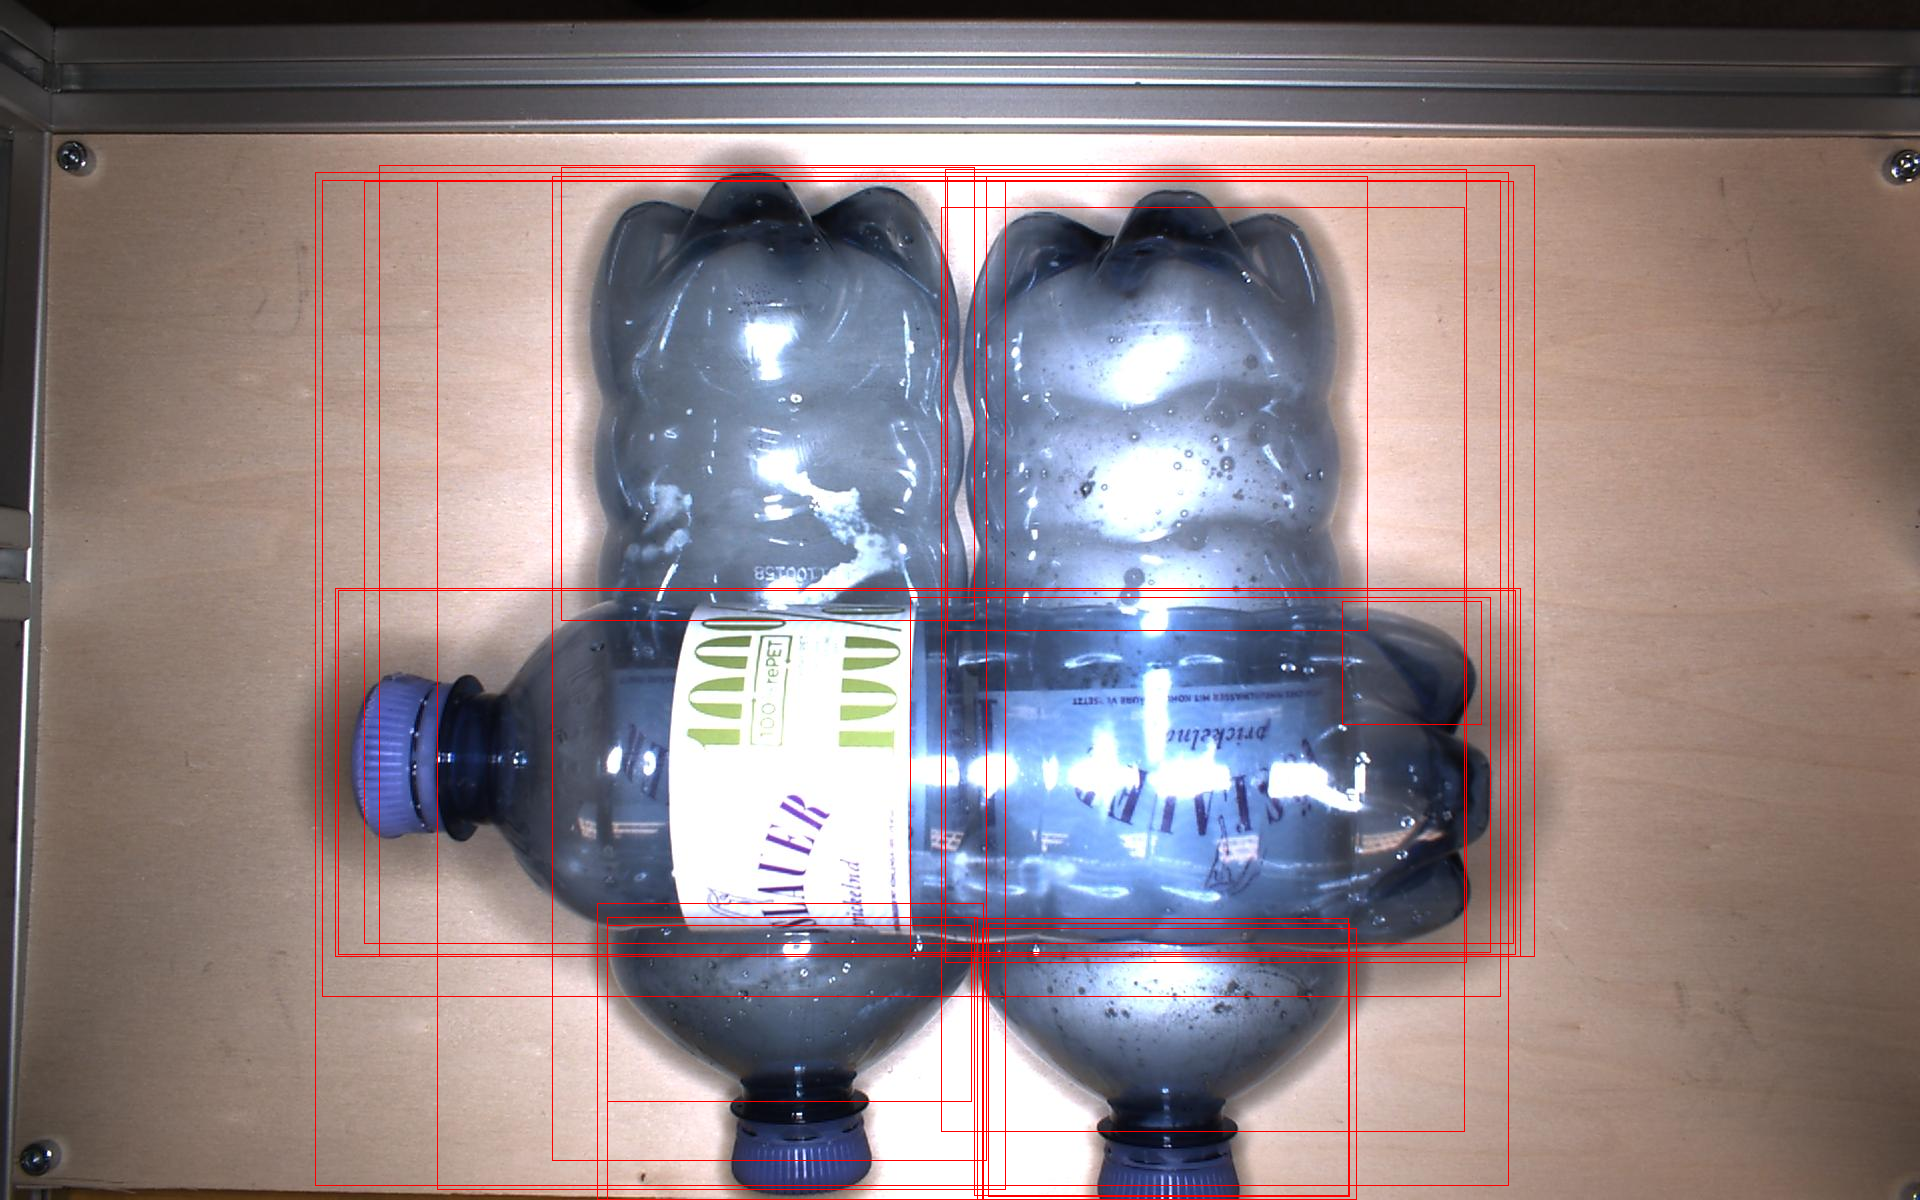

In [98]:
# visualize results with pillow
draw = ImageDraw.Draw(image)
for i in range(len(boxes)):
    if scores[i] > 0.1:
        draw.rectangle(((boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3])), outline="red")
        #draw.text((boxes[i][0], boxes[i][1]), str(labels[i]) + " " + str(scores[i]), fill="red")
image.show()

In [114]:
boxes_selected = boxes[scores > 0.1]
scores_selected = scores[scores > 0.1]

In [115]:
from torchvision.ops import nms

In [127]:
nms_out = nms(boxes_selected, scores_selected, iou_threshold=0.5)

In [128]:
boxes[nms_out].shape

torch.Size([10, 4])

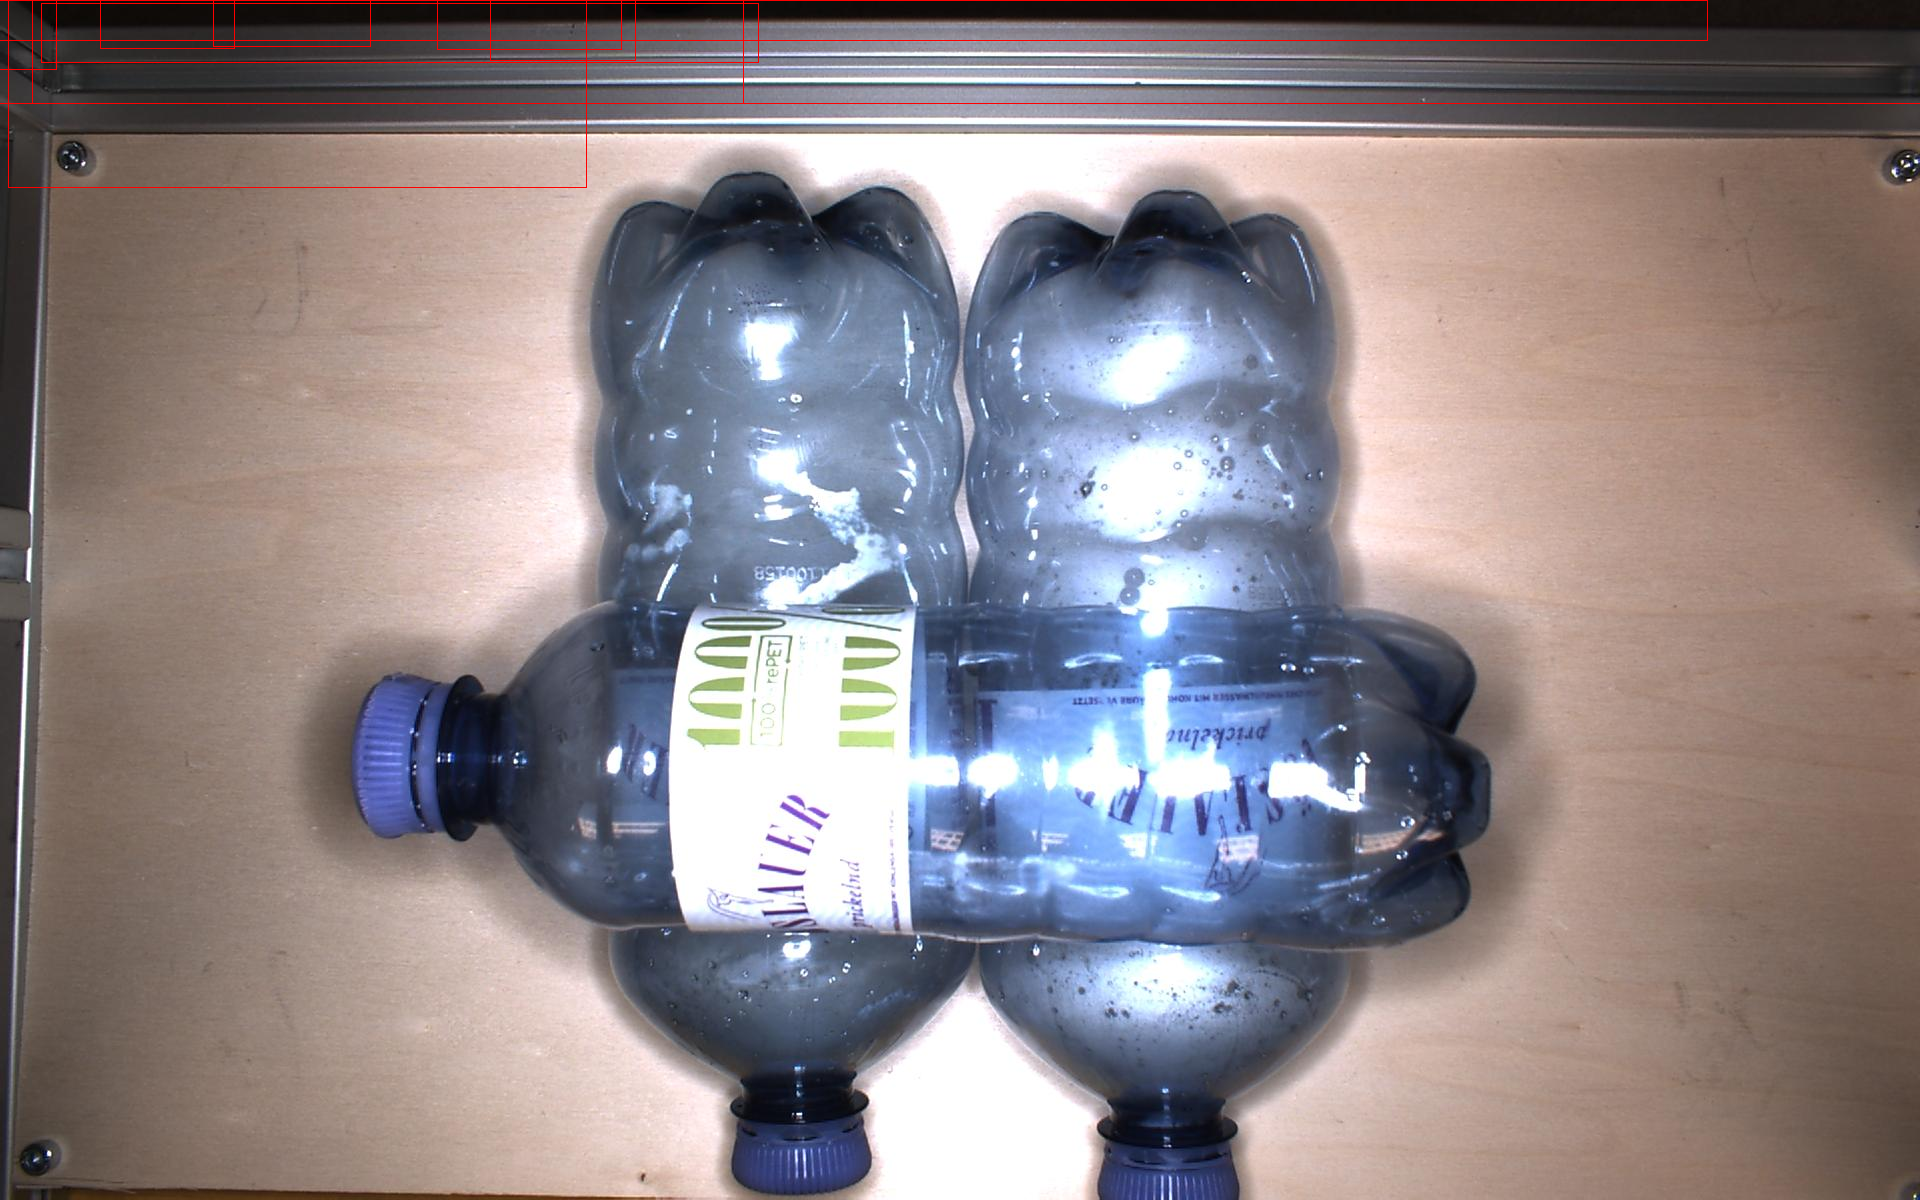

In [132]:
image_path = "/data/mburges/for_matthias/images_hackathon/image19.jpg"

# Load image
image = Image.open(image_path).convert("RGB")

# visualize results with pillow
draw = ImageDraw.Draw(image)
bboxes_pr = boxes[nms_out]
for i in range(len(bboxes_pr)):
    draw.rectangle(((bboxes_pr[i][0], bboxes_pr[i][1]), (bboxes_pr[i][2], bboxes_pr[i][3])), outline="red")
image.show()